In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud

%matplotlib inline

# notebook configurations
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# directories
DATA_DIR = './data/'

In [2]:
df = pd.read_csv(DATA_DIR + 'train.csv')\
       .rename(columns = {'comment_text': 'comment'})

Drop ```id``` column since:

In [3]:
len(df.id.unique()) == len(df)

True

In [4]:
df = df.drop(['id'], axis=1)

In [5]:
df.head()

,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df.isnull().any()

comment          False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

# I. The Classes 

In [7]:
CLASSES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
mask_labeled_rows = df[CLASSES].apply(lambda x: x.sum() > 0, axis=1)
df_labeled = df[mask_labeled_rows]

In [9]:
print("Fraction of labeled rows: {0}/{1} = {2}".format(len(df_labeled), len(df), 
                                                 round(len(df_labeled)/len(df),3)))

Fraction of labeled rows: 16225/159571 = 0.102


In [10]:
positives = df[CLASSES].sum()/len(df)*100
positives = positives.apply(lambda x: round(x,2)).sort_values(ascending = True)
negatives = 100 - positives
pct_classes = pd.concat([negatives, positives], axis=1)
pct_classes.columns = ['pct_-', 'pct_+']

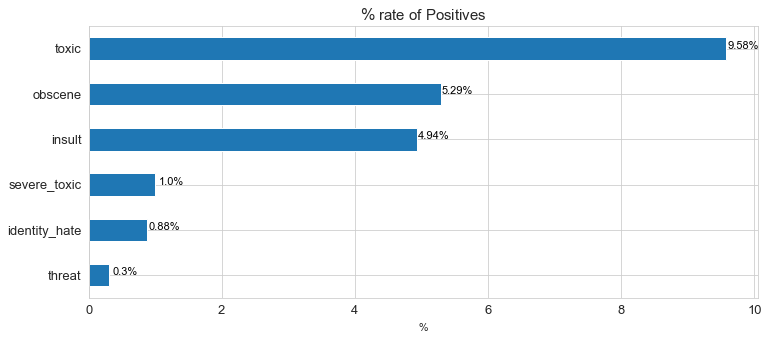

In [11]:
bar_positives = positives.plot(kind='barh', figsize=(12,5), fontsize=13);
plt.xlabel("$\%$");
#plt.xticks(rotation=20);
plt.title('$\%$ rate of Positives', size=15)
ax = plt.gca()
for bar in ax.patches:
    width = bar.get_width()
    ax.text(width + 0.25, bar.get_y() + bar.get_height()/2, str(width)+'%', 
             ha='center', color='black', fontsize=11);

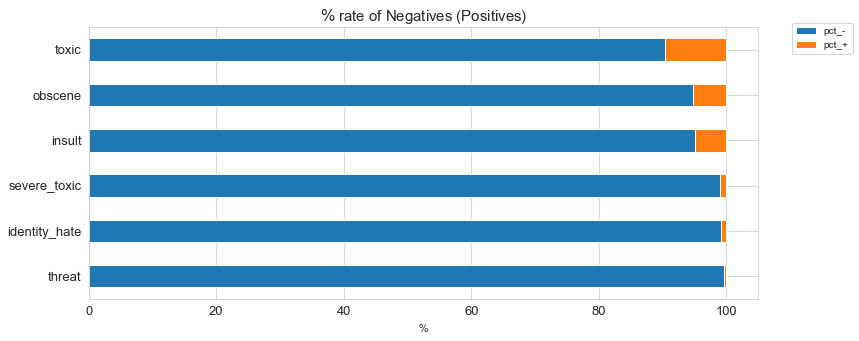

In [12]:
pct_classes.plot(kind='barh', stacked = True ,figsize=(12,5), fontsize=13);
plt.xlabel("$\%$");
plt.gca().legend(frameon=True,loc=(1.05,0.9));
plt.title('$\%$ rate of Negatives (Positives)', size=15);

In [13]:
df_no_labels = df_labeled[CLASSES].sum(axis=1).value_counts()

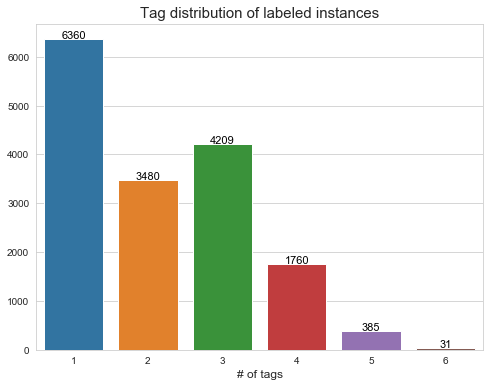

In [14]:
plt.figure(figsize=(8,6))
bars = sns.barplot(x=df_no_labels.index, y=df_no_labels.values)
for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, str(int(height)), 
             ha='center', color='black', fontsize=11);
plt.title('Tag distribution of labeled instances', size=15);
plt.xlabel('# of tags', size=12);

In [15]:
ids_per_class = {}
for col in CLASSES:
    labeled_rows_per_class = df_labeled[df_labeled[col] != 0].index
    ids_per_class[col] = set(labeled_rows_per_class)

In [16]:
pct_intesection = lambda set1, set2: round(len(set1.intersection(set2))/len(set1),2)

intersection_matrix = []
for key1 in CLASSES:
    intersection_list = []
    for key2 in CLASSES:
        intersection_list.append(pct_intesection(ids_per_class[key1], ids_per_class[key2]))
    intersection_matrix.append(intersection_list)
    
df_intersection = pd.DataFrame(intersection_matrix, columns = CLASSES, index = CLASSES)

In [17]:
df_padding = pd.DataFrame([0, 0, 0, 0, 0, 0 ], 
                          index = CLASSES, 
                          columns = ['padding']
                         ).T
df_intersection_padded = pd.concat([df_padding, df_intersection, df_padding])
                             

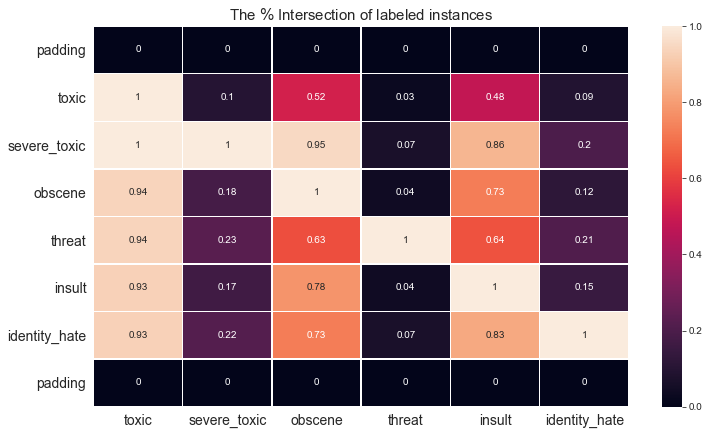

In [18]:
# bug with new version of matplotlib (cropped ends)
fig, ax = plt.subplots(1,1, figsize=(12,7))
sns.heatmap(df_intersection_padded, linewidth=0.5, annot=True);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.title("The $\%$ Intersection of labeled instances", size=15);

### Comment:
- if toxic then ~50% chance to be obscene or insult
- if severe_toxic then def toxic, and also very high chance (>80%) to be obscene or insult
- if obscene then most likely toxic, and high chance (>60%) to be insult
- if threat then most likely toxic, and high chance to be obscene or insult
- if insult then most likely toxic, and high chance to be obscene
- if identity_hate then most likely toxic, and high chance to be obscene and very high chance to be insult

# II. The comments

In [19]:
df_comment = df[['comment']]

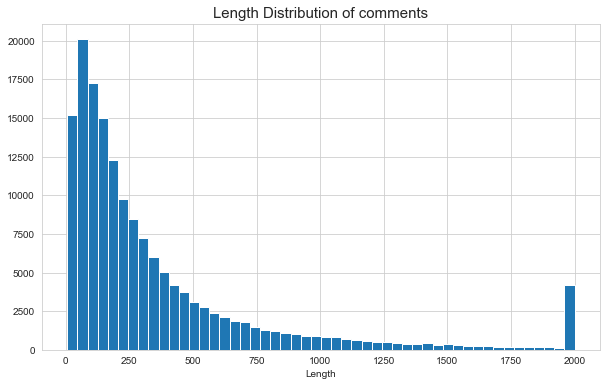

In [20]:
cutoff_length = 2000
df_comment.applymap(lambda x: len(x) if len(x)<cutoff_length else cutoff_length)\
          .hist(bins=50, figsize=(10,6));
plt.title('Length Distribution of comments', size=15);
plt.xlabel('Length');

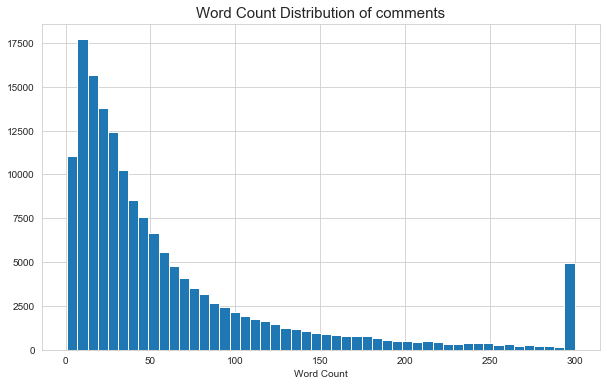

In [21]:
cutoff_word_count = 300
df_comment.applymap(lambda x: len(x.split()) if len(x.split())<cutoff_word_count else cutoff_word_count)\
          .hist(bins=50, figsize=(10,6));
plt.title('Word Count Distribution of comments', size=15);
plt.xlabel('Word Count');

## WordCLouds

In [91]:
clean_ids = set(df.index)
for ids in ids_per_class.values():
    clean_ids = clean_ids.difference(ids)

ids_per_class['clean'] = clean_ids

In [98]:
def plot_wordcloud(CLASS):
    class_ids = list(ids_per_class[CLASS])
    text = df_comment.iloc[class_ids].values
    text = " ".join(text.flatten().tolist())
    
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=40)
    wc.generate(text)
    
    plt.figure(figsize=(10,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Frequent Words in {CLASS.upper()} Comments", fontsize=15)
    

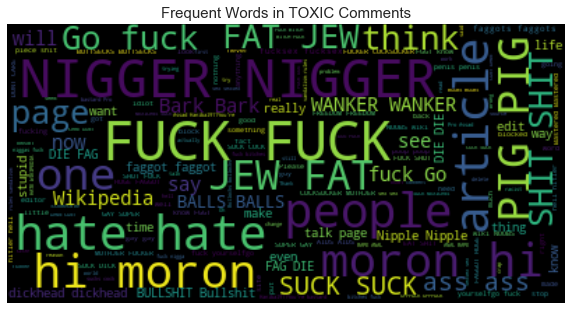

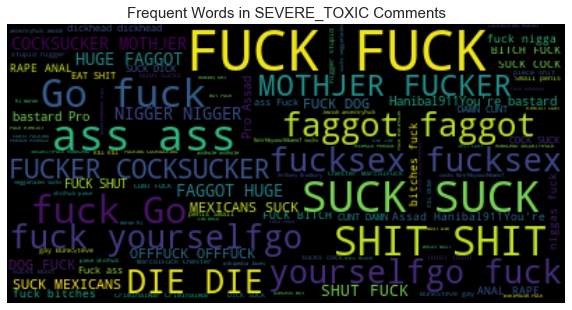

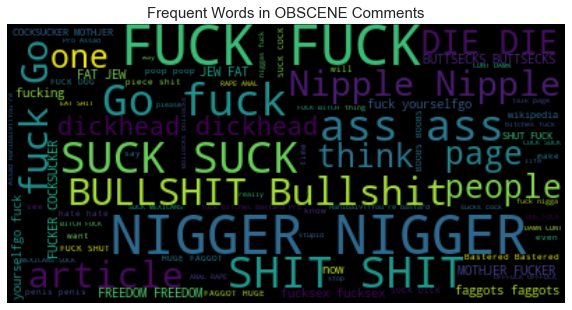

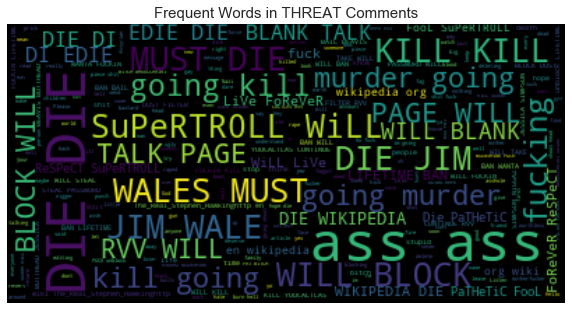

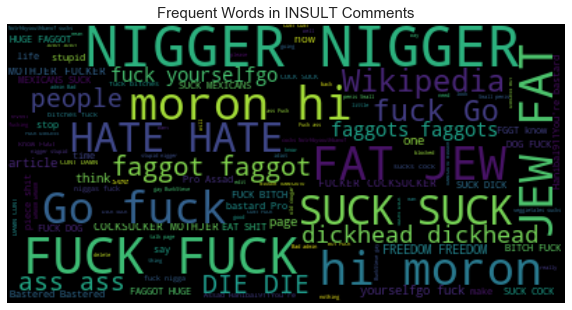

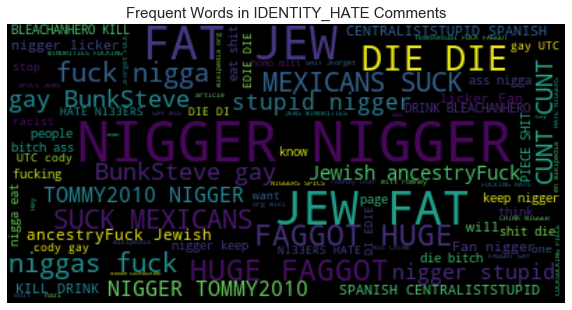

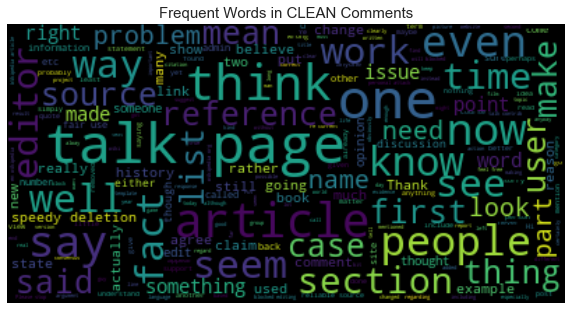

In [99]:
for CLASS in ids_per_class.keys():
    plot_wordcloud(CLASS)